In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                cartopy_ylim, latlon_coords, interplevel, extract_times)

In [2]:
# Load and open netcdf (wrf) file
ncfile = Dataset("../brianjs/MCS_LLJ_study/WRF_3.6.1_3km/wrfout_d01_2015-08-22_1200_UTC_WSM6_YSU.nc")

In [3]:
# Discover domain of wrf output with regards to lat/lon
lat = getvar(ncfile, "lat")
lon = getvar(ncfile, "lon")

In [4]:
# Get python variables from wrf variables (num slot sets time)
dbz = getvar(ncfile, "dbz",18) # Reflectivity
slp = getvar(ncfile, "slp",18) # Mean Sea Level Pressure in hPa
p = getvar(ncfile, "pressure",18) # Pressure in hPa
z = getvar(ncfile, "z",18,units="m") # Height in m
ua = getvar(ncfile, "ua",18) # Zonal component of wind in m/s
va = getvar(ncfile, "va",18) # Meridional component of wind in m/s
wspd = getvar(ncfile, "wspd_wdir",18) # Wind Speed & Direction in m/s

In [5]:
# Create Composite Reflectivity
dBZ = np.zeros(dbz[0,0].shape)
dBZ = np.max(dbz, axis=0)
for i in range(len(dbz[1,:,1])):
    for j in range(len(dbz[1,1,:])):
        dBZ[i,j] = np.max(dbz[:,i,j])

In [6]:
# Interpolate geopotential height, u, v, to 900 hPa
ht_900 = interplevel(z,p,900)
u_900 = interplevel(ua,p,900)
v_900 = interplevel(va,p,900)
wspd_900 = interplevel(wspd,p,900)

print(np.max(u_900))
print(np.max(v_900))

<xarray.DataArray 'ua_900_hPa' ()>
array(27.307790756225586)
Coordinates:
    Time     datetime64[ns] 2015-08-23T06:00:00
<xarray.DataArray 'va_900_hPa' ()>
array(24.888822555541992)
Coordinates:
    Time     datetime64[ns] 2015-08-23T06:00:00


In [7]:
# Smooth reflectivity and geopotential height
smooth_dBZ = smooth2d(dBZ, 5)
smooth_ht = smooth2d(ht_900, 10)

In [8]:
# Get cartopy mapping (& projections)
lats, lons = latlon_coords(dbz)
cart_proj = get_cartopy(dbz)

# Create Figure
fig = plt.figure(figsize=(14,11))

# Set GeoAxes to projection used by wrf
ax = plt.axes(projection=cart_proj)

In [10]:
print(lons)

<xarray.DataArray 'XLONG' (south_north: 532, west_east: 532)>
array([[-104.032013, -104.000732, -103.969452, ...,  -87.390564,  -87.359253,
         -87.328003],
       [-104.034897, -104.003601, -103.97229 , ...,  -87.387695,  -87.356384,
         -87.325104],
       [-104.037781, -104.00647 , -103.975159, ...,  -87.384827,  -87.353516,
         -87.322205],
       ..., 
       [-105.894653, -105.856506, -105.818344, ...,  -85.541656,  -85.50351 ,
         -85.465332],
       [-105.898956, -105.860794, -105.822617, ...,  -85.537384,  -85.499207,
         -85.46106 ],
       [-105.903259, -105.865082, -105.826904, ...,  -85.533112,  -85.494934,
         -85.456726]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -104.032 -104.001 -103.969 ...
    XLAT     (south_north, west_east) float32 31.5773 31.5798 31.5822 ...
    Time     datetime64[ns] 2015-08-23T06:00:00
Dimensions without coordinates: south_north, west_east


In [20]:
# Download/Add geographical lines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                            name='admin_1_states_provinces_shp')
ax.add_feature(states,linewidth=0.5,edgecolor='black')
ax.coastlines('50m',linewidth=0.8)

In [21]:
# Make filled contours for the composite reflectivity
levels = [5,10,15,20,25,30,35,40,45,50,55,60]
plt.contourf(to_np(lons), to_np(lats), to_np(dBZ), levels,
                  transform=crs.PlateCarree(), cmap=get_cmap("jet"))

In [22]:
# Add 900 hPa wind barbs for every 25th data point
# 5 m/s per half line, 10 m/s per line, 50 m/s per flag
plt.barbs(to_np(lons[::25,::25]), to_np(lats[::25,::25]),
         to_np(u_900[::25,::25]), to_np(v_900[::25,::25]),
         transform=crs.PlateCarree(), length=6,
         barb_increments=dict(half=5,full=10,flag=50))

/home/nvertz/anaconda3/lib/python3.6/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/nvertz/anaconda3/lib/python3.6/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


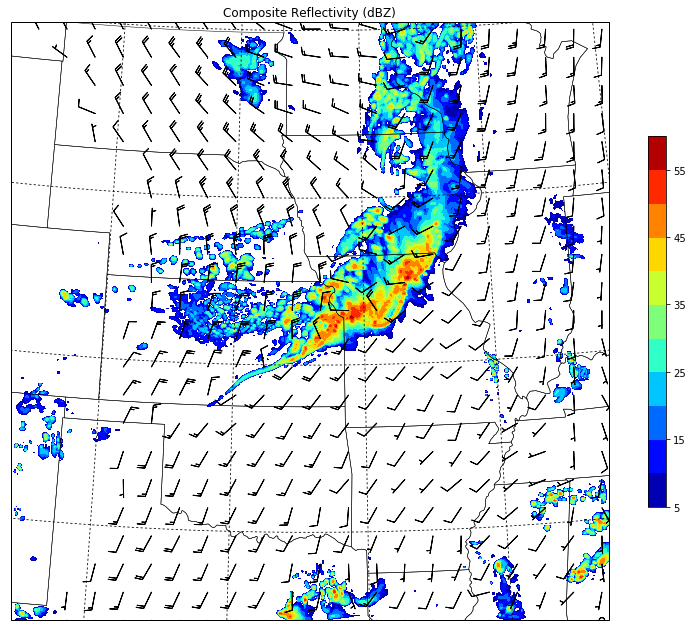

In [23]:
# Add colorbar, set Map Limits, add lat/lon lines, show it!
plt.colorbar(ax=ax, shrink=0.62)

ax.set_xlim(cartopy_xlim(dbz))
ax.set_ylim(cartopy_ylim(dbz))

xticks = [-106,-102,-98,-94,-90,-86]
yticks = [30,34,38,42,46,50]
ax.gridlines(xlocs=xticks, ylocs=yticks, color="black", linestyle="dotted")
plt.title("Composite Reflectivity (dBZ)")
plt.show()